# Bottom-Up Cube (BUC) Algorithm

In [1]:
%pip install memory_profiler

In [26]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations
from memory_profiler import profile

In [27]:
data = pd.read_csv('Electric_Vehicle_Data.csv')
data.head(5)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WAUTPBFF4H,King,Seattle,WA,98126.0,2017,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,0,34.0,235085336,POINT (-122.374105 47.54468),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,WAUUPBFF2J,Thurston,Olympia,WA,98502.0,2018,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,0,22.0,237896795,POINT (-122.943445 47.059252),PUGET SOUND ENERGY INC,5.306701e+10
2,5YJSA1E22H,Thurston,Lacey,WA,98516.0,2017,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,22.0,154498865,POINT (-122.78083 47.083975),PUGET SOUND ENERGY INC,5.306701e+10
3,1C4JJXP62M,Thurston,Tenino,WA,98589.0,2021,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25,0,20.0,154525493,POINT (-122.85403 46.856085),PUGET SOUND ENERGY INC,5.306701e+10
4,5YJ3E1EC9L,Yakima,Yakima,WA,98902.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,0,14.0,225996361,POINT (-120.524012 46.5973939),PACIFICORP,5.307700e+10


In [28]:
print(len(data))

181458


In [30]:
class Generalizer:
  def __init__(self, df) -> None:
    self.data = df.copy(deep=True)

  def fill_zero_with_nan(self, target_column):
    self.data.loc[self.data[target_column] == 0, target_column] = np.nan

  def generalise_continous_to_categorical(self, target_column, no_of_categories, labels=None):
    bins = pd.qcut(self.data[target_column], no_of_categories, retbins=True)[1]

    if labels == None:
      labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
    else:
      labels = [f"{labels[i]} ({int(bins[i])}-{int(bins[i+1])})" for i in range(len(bins)-1)]

    self.data[target_column] = pd.cut(self.data[target_column], bins=bins, include_lowest=True, labels=labels)

  def generalize_year(self):
    self.generalise_continous_to_categorical('Model Year', no_of_categories=3)

  def generalize_range(self):
    self.fill_zero_with_nan('Electric Range')
    self.generalise_continous_to_categorical('Electric Range', no_of_categories=3, labels=['Short Range', 'Medium Range', 'Long Range'] )

  def generalize_Electric_Utility(self):
    self.data.dropna(subset=['Electric Utility'], inplace=True)
    self.data['Electric Utility'] = self.data['Electric Utility'].apply(lambda x: x.split('||')[0])

  def generalize_ev_type(self):
    mp = {
      'Battery Electric Vehicle (BEV)': 'BEV',
      'Plug-in Hybrid Electric Vehicle (PHEV)': 'PHEV'
    }
    self.data['Electric Vehicle Type'] = self.data['Electric Vehicle Type'].apply(lambda x: mp[x])

  def generalize_cafv_eligibility(self):
    mp = {
      'Not eligible due to low battery range': 'NO',
      'Eligibility unknown as battery range has not been researched': 'NO',
      'Clean Alternative Fuel Vehicle Eligible': 'YES'
    }
    self.data['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = self.data['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].apply(lambda x: mp[x])

  def remove_unused_fields(self):
    unnecessary_fields = ['VIN (1-10)', 'City', 'State', 'Model', 'Postal Code', 'Base MSRP', 'DOL Vehicle ID', 'Vehicle Location', 'Legislative District', '2020 Census Tract']
    self.data.drop(labels=unnecessary_fields, inplace=True, axis=1)

  def generalize(self):
    self.generalize_year()
    self.generalize_range()
    self.generalize_Electric_Utility()
    self.generalize_ev_type()
    self.generalize_cafv_eligibility()

  def get_generalised(self):
    return self.data

In [29]:
def get_pivot_table(df, index_col, other_cols):
  pivot_table = pd.pivot_table(df, index=index_col, columns=other_cols, aggfunc='size', fill_value=0)
  pivot_table['Total'] = pivot_table.sum(axis=1)
  pivot_table.loc['Total'] = pivot_table.sum(axis=0)
  return pivot_table

In [ ]:
gen = Generalizer(data)

# print(gen.get_generalised()['Base MSRP'].unique())

gen.remove_unused_fields()
gen.generalize()
temp = gen.get_generalised()

In [ ]:
evType_vs_range = get_pivot_table(temp, index_col='Electric Vehicle Type', other_cols='Electric Range')

evType_vs_range

Electric Range,Short Range (6-37),Medium Range (37-208),Long Range (208-337),Total
Electric Vehicle Type,,,,
BEV,9,19149,28082,47240
PHEV,29143,10342,0,39485
Total,29152,29491,28082,86725


In [ ]:
evType_vs_utility = get_pivot_table(temp, index_col='Electric Vehicle Type', other_cols='Electric Utility')

evType_vs_utility

Electric Utility,AVISTA CORP,BONNEVILLE POWER ADMINISTRATION,CITY OF BLAINE - (WA),CITY OF CHENEY - (WA),CITY OF CHEWELAH,CITY OF SEATTLE - (WA),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),CITY OF SUMAS - (WA),CITY OF TACOMA - (WA),MODERN ELECTRIC WATER COMPANY,...,PACIFICORP,PORTLAND GENERAL ELECTRIC CO,PUD NO 1 OF CHELAN COUNTY,PUD NO 1 OF DOUGLAS COUNTY,PUD NO 1 OF OKANOGAN COUNTY,PUD NO 1 OF PEND OREILLE COUNTY,PUD NO 1 OF WHATCOM COUNTY,PUD NO 2 OF GRANT COUNTY,PUGET SOUND ENERGY INC,Total
Electric Vehicle Type,,,,,,,,,,,,,,,,,,,,,
BEV,269,25350,153,35,5,1,25633,4,232,827,...,930,4,856,280,68,36,25,415,86303,141970
PHEV,140,9653,40,10,4,0,6379,3,48,327,...,411,1,222,87,37,20,16,170,21672,39485
Total,409,35003,193,45,9,1,32012,7,280,1154,...,1341,5,1078,367,105,56,41,585,107975,181455


In [ ]:
evType_vs_cafv = get_pivot_table(temp, index_col='Electric Vehicle Type', other_cols='Clean Alternative Fuel Vehicle (CAFV) Eligibility')

evType_vs_cafv

Clean Alternative Fuel Vehicle (CAFV) Eligibility,NO,YES,Total
Electric Vehicle Type,,,
BEV,94739,47231,141970
PHEV,19903,19582,39485
Total,114642,66813,181455


In [31]:
def clean_df(df):
  remove_columns = ['VIN (1-10)','State','City','Postal Code','Base MSRP', 'Legislative District', 'DOL Vehicle ID','Vehicle Location', '2020 Census Tract']
  df = df.drop(columns=remove_columns)
  df = df.dropna()
  df = df.reset_index(drop=True)
  return df

In [32]:
data = pd.read_csv('Electric_Vehicle_Data.csv')
columns = data.columns
print('Original columns:',columns)
data = clean_df(data)

gen = Generalizer(data)

gen.generalize_year()
gen.generalize_range()
gen.generalize_Electric_Utility()

data = gen.get_generalised()

data.to_csv('preprocessed_data.csv', encoding='utf-8', index=False, header=True)
print('New columns:', data.columns)

Original columns: Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')
New columns: Index(['County', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Electric Utility'],
      dtype='object')


In [33]:
data

,County,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility
0,King,1997-2020,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,Short Range (6-37),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)
1,Thurston,1997-2020,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,Short Range (6-37),PUGET SOUND ENERGY INC
2,Thurston,1997-2020,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),PUGET SOUND ENERGY INC
3,Thurston,2020-2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,Short Range (6-37),PUGET SOUND ENERGY INC
4,Yakima,1997-2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),PACIFICORP
...,...,...,...,...,...,...,...,...
181450,Douglas,2020-2023,LUCID,AIR,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,NaN,PUD NO 1 OF DOUGLAS COUNTY
181451,Spokane,2020-2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,Short Range (6-37),BONNEVILLE POWER ADMINISTRATION
181452,King,2020-2023,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,NaN,PUGET SOUND ENERGY INC
181453,Clark,1997-2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),BONNEVILLE POWER ADMINISTRATION


In [34]:
print(data.head(10))

      County Model Year       Make     Model  \
0       King  1997-2020       AUDI        A3   
1   Thurston  1997-2020       AUDI        A3   
2   Thurston  1997-2020      TESLA   MODEL S   
3   Thurston  2020-2023       JEEP  WRANGLER   
4     Yakima  1997-2020      TESLA   MODEL 3   
5   Thurston  2020-2023       JEEP  WRANGLER   
6     Kitsap  1997-2020  CHEVROLET      VOLT   
7  Snohomish  1997-2020      TESLA   MODEL 3   
8       King  2020-2023       AUDI        Q5   
9   Thurston  1997-2020  CHEVROLET      VOLT   

                    Electric Vehicle Type  \
0  Plug-in Hybrid Electric Vehicle (PHEV)   
1  Plug-in Hybrid Electric Vehicle (PHEV)   
2          Battery Electric Vehicle (BEV)   
3  Plug-in Hybrid Electric Vehicle (PHEV)   
4          Battery Electric Vehicle (BEV)   
5  Plug-in Hybrid Electric Vehicle (PHEV)   
6  Plug-in Hybrid Electric Vehicle (PHEV)   
7          Battery Electric Vehicle (BEV)   
8  Plug-in Hybrid Electric Vehicle (PHEV)   
9  Plug-in Hybrid Ele

## BUC Implementation - In Memory

In [35]:
def buc(data, dimensions, min_support=0, prefix=()):
    if len(dimensions) == 0:
        count = len(data)
        if count >= min_support:
            result = {tuple(prefix): count}
        else:
            result = {}
    else:
        dim = dimensions[0]
        rest_dims = dimensions[1:]
        dim_values = data[dim].unique()

        result = {}
        for value in dim_values:
            subset = data[data[dim] == value]
            new_prefix = prefix + ((dim, value),)
            subresult = buc(subset, rest_dims, min_support, new_prefix)
            result.update(subresult)

        if len(dim_values) > 1:
            all_prefix = prefix + ((dim, 'ALL'),)
            all_result = buc(data, rest_dims, min_support, all_prefix)
            result.update(all_result)

    return result

In [ ]:
dimensions = [column for column in data.columns]
minsup=10000
measures = ['Count']
df=pd.DataFrame(data)
result = buc(df, dimensions, minsup)

In [ ]:
result_list = []
for key, value in result.items():
    row_data = {dim: dim_value for dim, dim_value in key}
    row_data[measures[0]] = value
    result_list.append(row_data)

result_df = pd.DataFrame(result_list, columns=dimensions+measures)
result_df.to_csv('buc_without_optimization.csv', encoding='utf-8', index=False, header=True)
result_df.head(10)

,County,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility,Count
0,King,1997-2020,TESLA,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,12151
1,King,1997-2020,TESLA,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,ALL,14121
2,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,14735
3,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,PUGET SOUND ENERGY INC,15040
4,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,ALL,24235
5,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),ALL,Long Range (208-337),ALL,14735
6,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),ALL,ALL,PUGET SOUND ENERGY INC,15053
7,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),ALL,ALL,ALL,24266
8,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,Medium Range (37-208),ALL,11993
9,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,14735


## BUC Implementation - Out-of-Memory

In [36]:
def buc_withpaging(dimensions, min_support=0, chunk_size=None):
    def process(data, dimensions, prefix=()):
      if len(dimensions) == 0:
        count = len(data)
        result = {tuple(prefix): count}
      else:
          dim = dimensions[0]
          rest_dims = dimensions[1:]
          dim_values = data[dim].unique()

          result = {}
          for value in dim_values:
              subset = data[data[dim] == value]
              new_prefix = prefix + ((dim, value),)
              subresult = process(subset, rest_dims, new_prefix)
              result.update(subresult)

          if len(dim_values) > 1:
              all_prefix = prefix + ((dim, 'ALL'),)
              all_result = process(data, rest_dims, all_prefix)
              result.update(all_result)

      return result

    result = {}
    i = 0
    for chunk in pd.read_csv('preprocessed_data.csv', chunksize=chunk_size):
        print(i)
        i = i+1

        chunk_result = process(chunk, dimensions)

        for key, value in chunk_result.items():
          if key in result:
              result[key] += value
          else:
              result[key] = value

    result = {k: v for k, v in result.items() if v >= min_support}

    return result

In [ ]:
dimensions = [column for column in data.columns]
minsup=10000
measures = ['Count']
prefix = ()
chunk_size = 10000
df=pd.DataFrame(data)
result = buc_withpaging(dimensions, minsup, chunk_size)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [ ]:
result_list = []
for key, value in result.items():
    row_data = {dim: dim_value for dim, dim_value in key}
    row_data[measures[0]] = value
    result_list.append(row_data)

result_df = pd.DataFrame(result_list, columns=dimensions+measures)
result_df.to_csv('buc_with_pagination.csv', encoding='utf-8', index=False, header=True)
result_df.head(10)

,County,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility,Count
0,King,1997-2020,TESLA,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,12151
1,King,1997-2020,TESLA,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,ALL,14121
2,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,14735
3,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,PUGET SOUND ENERGY INC,15040
4,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,ALL,24235
5,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,Medium Range (37-208),ALL,11993
6,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,14735
7,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,ALL,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),10393
8,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,ALL,PUGET SOUND ENERGY INC,16855
9,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,ALL,ALL,27329


## Optimization Technique

## BUC - Apriori Pruning

In [11]:
def buc_pruning(data, dimensions, min_support=0, prefix=()):
    if len(dimensions) == 0:
        count = len(data)
        if count >= min_support:
            result = {tuple(prefix): count}
        else:
            result = {}
    else:
        dim = dimensions[0]
        rest_dims = dimensions[1:]
        dim_values = data[dim].unique()

        result = {}
        for value in dim_values:
            subset = data[data[dim] == value]
            count = len(subset)
            # Prune branches where the count is already less than min_support
            if count >= min_support:
                new_prefix = prefix + ((dim, value),)
                subresult = buc_pruning(subset, rest_dims, min_support, new_prefix)
                result.update(subresult)

        # Prune branches where the count is already less than min_support
        if len(dim_values) > 1:
            all_prefix = prefix + ((dim, 'ALL'),)
            all_count = len(data)
            if all_count >= min_support:
                all_result = buc_pruning(data, rest_dims, min_support, all_prefix)
                result.update(all_result)

    return result

In [ ]:
dimensions = [column for column in data.columns]
minsup=10000
measures = ['Count']
df=pd.DataFrame(data)
result = buc_pruning(df, dimensions, minsup)

In [ ]:
result_list = []
for key, value in result.items():
    row_data = {dim: dim_value for dim, dim_value in key}
    row_data[measures[0]] = value
    result_list.append(row_data)

result_df = pd.DataFrame(result_list, columns=dimensions+measures)
# result_df = result_df.sort_values(by=measures[0], ascending=False)
result_df.to_csv('buc_with_pruning.csv', encoding='utf-8', index=False, header=True)
result_df.head(10)

,County,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility,Count
0,King,1997-2020,TESLA,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,12151
1,King,1997-2020,TESLA,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,ALL,14121
2,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,14735
3,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,PUGET SOUND ENERGY INC,15040
4,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,ALL,ALL,24235
5,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),ALL,Long Range (208-337),ALL,14735
6,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),ALL,ALL,PUGET SOUND ENERGY INC,15053
7,King,1997-2020,ALL,ALL,Battery Electric Vehicle (BEV),ALL,ALL,ALL,24266
8,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,Medium Range (37-208),ALL,11993
9,King,1997-2020,ALL,ALL,ALL,Clean Alternative Fuel Vehicle Eligible,Long Range (208-337),ALL,14735


## Performance Analysis

### Plot of minsup vs runtime, keeping allotted memory fixed

In [37]:
df = pd.read_csv('preprocessed_data.csv')
dimensions = [column for column in df.columns]
minsup_list = [1000, 5000, 10000, 20000, 50000]
algo_list = ['unoptimized', 'with pruning']
time_list = []

performace_report = []

for algo in algo_list:
    for minsup in minsup_list:
        print('Computing for minsup', minsup)
        start_time = time.time()
        prefix = ()
        chunk_size = 1000
        result = None
        if(algo == 'unoptimized'):
            result = buc(df, dimensions, minsup, prefix)
        else:
            result = buc_pruning(df, dimensions, minsup, prefix)

        end_time = time.time()
        time_list.append(end_time - start_time)
        performace_report.append([algo, minsup, end_time - start_time])

performace_report = pd.DataFrame(performace_report, columns=['Algorithm', 'Minimum Support', 'Time Taken (s)'])

Computing for minsup 1000
Computing for minsup 5000
Computing for minsup 10000
Computing for minsup 20000
Computing for minsup 50000
Computing for minsup 1000
Computing for minsup 5000
Computing for minsup 10000
Computing for minsup 20000
Computing for minsup 50000


In [49]:
performace_report.to_csv('performance_report_minimum_support.csv', encoding='utf-8', index=False, header=True)

In [51]:
performace_report = pd.read_csv('performance_report_minimum_support.csv')
performace_report

,Algorithm,Minimum Support,Time Taken (s)
0,unoptimized,1000,74.293994
1,unoptimized,5000,71.948519
2,unoptimized,10000,74.216973
3,unoptimized,20000,73.719118
4,unoptimized,50000,73.505386
5,with pruning,1000,25.392084
6,with pruning,5000,20.904644
7,with pruning,10000,17.600266
8,with pruning,20000,15.589638
9,with pruning,50000,12.317946


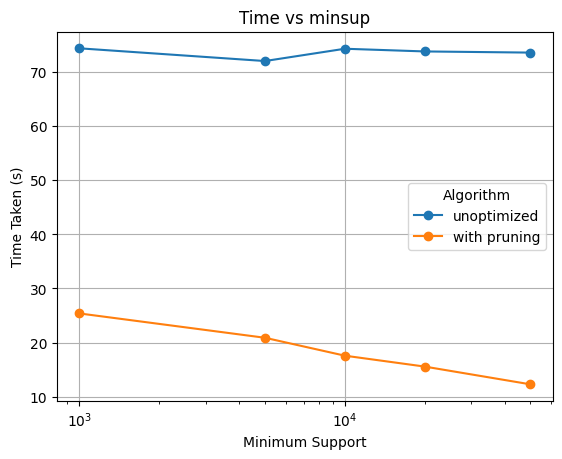

In [40]:
for algorithm in performace_report['Algorithm'].unique():
    subset = performace_report[performace_report['Algorithm'] == algorithm]
    plt.plot(subset['Minimum Support'], subset['Time Taken (s)'], marker='o', label=algorithm)

# plt.plot(performace_report['Minimum Support'], performace_report['Time Taken (ms)'])
plt.xlabel('Minimum Support')
plt.xscale('log')
plt.ylabel('Time Taken (s)')
plt.title('Time vs minsup')
plt.legend(title='Algorithm')
plt.grid(True)
plt.show()

### Plot of allotted memory vs. runtime, keeping minsup fixed

In [41]:
df = pd.read_csv('preprocessed_data.csv')
dimensions = [column for column in df.columns]
chunk_size_list = [1000, 5000, 10000, 20000, 50000]
minsup = 10000
time_list = []

performace_report_2 = []

for chunk_size in chunk_size_list:
    print('Computing for minsup', chunk_size)
    start_time = time.time()
    prefix = ()
    result = buc_withpaging(dimensions, minsup, chunk_size)
    end_time = time.time()
    time_list.append(end_time - start_time)
    performace_report_2.append([chunk_size, end_time - start_time])

performace_report_2 = pd.DataFrame(performace_report_2, columns=['Chunk Size', 'Time Taken (s)'])

Computing for minsup 1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
Computing for minsup 5000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
Computing for minsup 10000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
Computing for minsup 20000
0
1
2
3
4
5
6
7
8
9
Computing for minsup 50000
0
1
2
3


In [47]:
performace_report_2.to_csv('performance_report_chunk_sizes.csv', encoding='utf-8', index=False, header=True)

In [48]:
performace_report_2 = pd.read_csv('performance_report_chunk_sizes.csv')
performace_report_2

,Chunk Size,Time Taken (s)
0,1000,1026.760191
1,5000,460.920155
2,10000,315.948920
3,20000,218.444160
4,50000,135.002385


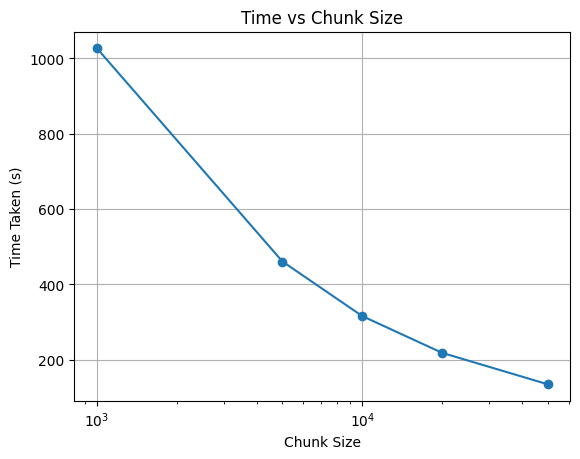

In [52]:
plt.plot(performace_report_2['Chunk Size'], performace_report_2['Time Taken (s)'], marker='o')
plt.xlabel('Chunk Size')
plt.ylabel('Time Taken (s)')
plt.title('Time vs Chunk Size')
plt.xscale('log')
plt.grid(True)
plt.show()

In [ ]:
def iceberg_apriori(data, dimensions, min_support):
  # print(dimensions)
  frequent_itemsets = []
  frequent_itemset_supports = []
  frequent_itemsets_k = []
  k = 1

  def init_candidates():
    potential_candiates = []
    for dim in dimensions:
      new_candidates = [{ dim: x } for x in data[dim].unique()]
      potential_candiates = potential_candiates + new_candidates

    return potential_candiates

  def get_supports(itemsets=[]):
    def get_support(itemset={}):
      query_string = ' & '.join([f"`{k}` == \"{v}\"" for k, v in itemset.items()])
      count = data.query(query_string).shape[0]
      return count

    return [get_support(itemset=it) for it in itemsets]

  def get_candidate_itemsets(itemsets=[]):
    def ismergable(it1, it2):
      # less than k-1 common keys means, on merging we get more than k+1 keys in resultant itemset.
      # k common keys means, on merging we get only k keys.
      if len(it1.keys() & it2.keys()) != k-1:
        return False

      # For all common keys, check if values are same in it1 and it2.
      for key in it1.keys() & it2.keys():
        if it1[key] != it2[key]:
          return False

      return True

    def merge_itemsets(it1, it2):
      new_itemset = {**it1, **it2}
      return new_itemset

    new_candidates = set()

    for it1 in itemsets:
      for it2 in itemsets:
        if(ismergable(it1, it2)):
          new_dict = merge_itemsets(it1, it2)
          new_candidates.add(frozenset(new_dict.items()))

    unique_dicts = [dict(fs) for fs in new_candidates]

    return unique_dicts

  for k in range(0, len(dimensions)):

    print(k, ': computing potential candidates')
    potential_candidates = []
    if(k == 0):
      potential_candidates = init_candidates()
    else:
      potential_candidates = get_candidate_itemsets(frequent_itemsets_k)
    print(k, ': found', len(potential_candidates), 'potential candidates')
    # print('----------------------------')
    # print(potential_candidates)
    # print('---------------------')

    print(k, ': computing supports candidates')
    supports = get_supports(potential_candidates)

    print(k, ': computing candidates with supports')
    new_candidates = []
    new_candidates_supports = []

    for i, candidate in enumerate(potential_candidates):
      if(supports[i] >= min_support):
        new_candidates.append(candidate)
        new_candidates_supports.append(supports[i])

    print(k, ': found', len(new_candidates), 'candidates with supports')
    # print('----------------------------')
    # print(new_candidates)
    # print('---------------------')

    print(k, ': adding to frequent itemsets')
    frequent_itemsets = frequent_itemsets + new_candidates
    frequent_itemset_supports = frequent_itemset_supports + new_candidates_supports
    frequent_itemsets_k = new_candidates

  return frequent_itemsets, frequent_itemset_supports


In [ ]:
data = pd.read_csv('preprocessed_data.csv')

data['Model Year'] = data['Model Year'].astype(str)

# gen = Generalizer(data)
# gen.generalize_Electric_Utility()
# gen.generalize_cafv_eligibility()
# gen.generalize_ev_type()

# data = gen.get_generalised()

dimensions = [column for column in data.columns]
minsup=10000

result, supports = iceberg_apriori(data, dimensions, min_support=minsup)

0 : computing potential candidates
0 : found 410 potential candidates
0 : computing supports candidates
0 : computing candidates with supports
0 : found 23 candidates with supports
0 : adding to frequent itemsets
1 : computing potential candidates
1 : found 230 potential candidates
1 : computing supports candidates
1 : computing candidates with supports
1 : found 94 candidates with supports
1 : adding to frequent itemsets
2 : computing potential candidates
2 : found 474 potential candidates
2 : computing supports candidates
2 : computing candidates with supports
2 : found 148 candidates with supports
2 : adding to frequent itemsets
3 : computing potential candidates
3 : found 388 potential candidates
3 : computing supports candidates
3 : computing candidates with supports
3 : found 119 candidates with supports
3 : adding to frequent itemsets
4 : computing potential candidates
4 : found 183 potential candidates
4 : computing supports candidates
4 : computing candidates with supports
4 :

In [ ]:
measures = ['Count']

result_list = []
for it, sup in zip(result, supports):
    row_data = {dim: (it[dim] if dim in it else 'ALL') for dim in dimensions}
    row_data[measures[0]] = sup
    result_list.append(row_data)

result_df = pd.DataFrame(result_list, columns=dimensions+measures)
# result_df = result_df.sort_values(by=measures[0], ascending=False)
result_df.to_csv('iceberg.csv', encoding='utf-8', index=False, header=True)
result_df.head(10)

,County,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility,Count
0,King,ALL,ALL,ALL,ALL,ALL,ALL,ALL,94460
1,Snohomish,ALL,ALL,ALL,ALL,ALL,ALL,ALL,21439
2,Clark,ALL,ALL,ALL,ALL,ALL,ALL,ALL,10675
3,Pierce,ALL,ALL,ALL,ALL,ALL,ALL,ALL,14043
4,ALL,1997-2020,ALL,ALL,ALL,ALL,ALL,ALL,66307
5,ALL,2020-2023,ALL,ALL,ALL,ALL,ALL,ALL,105349
6,ALL,ALL,TESLA,ALL,ALL,ALL,ALL,ALL,80816
7,ALL,ALL,CHEVROLET,ALL,ALL,ALL,ALL,ALL,13864
8,ALL,ALL,NISSAN,ALL,ALL,ALL,ALL,ALL,14037
9,ALL,ALL,ALL,MODEL 3,ALL,ALL,ALL,ALL,30149
